#A brief tutorial on stacking image cross-sections to construct views of a 3D object

In this tutorial we will take a stack of MRI images of a brain and skull then denoise and segment the images. These will be rough segmentations and denoising. The segmentation is to identify types of tissues. We will then identify surfaces corresponding to the tissues. Finally we will plot these surfaces. The data object used to plot the surfaces can be used to measure the physical properties of the object. 

This tutorial combines information from 3 sources which you should absolutely check out. They offer useful additions such as better segmenting through the use of informed medical imaging units (e.g. housefield units), medical imaging formats such as DICOM ([example 1](https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial)), plotting and segmenting with RGB values instead of the rudimentary gray scale values ([example 2](https://plot.ly/python/visualizing-mri-volume-slices/)), and finally the resource we most closely follow shows how this process can be used to make scientifically useful measurements of mineral properties when applied in the original context ([example 3](http://42eli.github.io/)).  

##Import data
First we need to install some software and get the data imaging data.

In [1]:
# requirements
!pip install pyamg
!pip install opencv-python
# data
!apt-get install subversion
!svn checkout "https://github.com/jojker/PML_Workshops/trunk/Summer 2019/Day 2 - Goal 1 - Turning Images into Data/Ex 6 - 3D structure from 2D slices/Data"

     |████████████████████████████████| 6.4MB 4.8MB/s 
     |████████████████████████████████| 153kB 45.5MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 4 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/

## Now import some prerequisites

In [0]:
#make IPython notebook matplotlib plot inline
%matplotlib inline 

#import modules and libraries
import glob
from PIL import Image, ImageOps
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage.io import imsave

>In order to operate the images in 3D, we need to import and stack the images successively. I do this by creating a three-dimensional array as a 'container' of the values of the images, and importing the pixel values of the images into the 3D numpy array. Each element in this array represents the value of the corresponding voxel in 3D.

~ text from [example 3](http://42eli.github.io/)

The result is the object "imgs" which is  a 3D array that contains all the data needed for the 3D object.

In [3]:
#import the image file names into a list which sorted by file names.
infiles = sorted(glob.glob('Data/unstacked/*.tif'))

#open the first image to acquire image size
im = Image.open(infiles[0])
im = ImageOps.grayscale(im) # JKJ added this grayscale line

#create an 'empty' array filled with zeros, (Slices X width X length) is the shape of the array.
imgs = np.zeros((len(infiles),im.size[1],im.size[0]))

#loop the files, each iteration adds one slice layer into the array.
i = 0
for imfile in infiles:
    im = Image.open(imfile)
    im = ImageOps.grayscale(im) # JKJ added this grayscale line
    imgs[i,:,:] = np.array(im)
    i+=1
    
print(imgs.dtype)
print(imgs.shape)

float64
(157, 189, 68)


## Create a function to plot data in 3 imaging planes

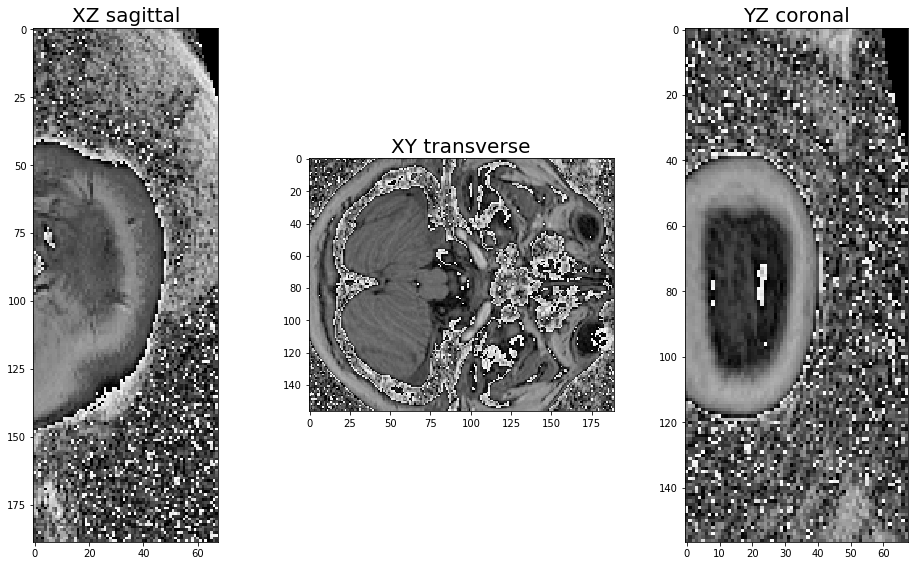

In [4]:
def plot_3_planes(img_stack):
  fig, axes = plt.subplots(nrows=1, ncols=3)
  ax0, ax1, ax2= axes
  ax0.imshow(img_stack[0],cmap='gray')
  ax0.set_title('XZ sagittal',fontsize=20)
  ax1.imshow(img_stack[:,:,0],cmap='gray')
  ax1.set_title('XY transverse',fontsize=20)
  ax2.imshow(img_stack[:,0,:],cmap='gray')
  ax2.set_title('YZ coronal',fontsize=20)

  plt.tight_layout()
  fig.set_size_inches(15, 9)
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
  
plot_3_planes(imgs)

##Pre-processing
>Pre-processing includes steps such as adjusting contrast, rescaling values, finding objects, denoising etc., which are the preparation steps for later image processing. How much pre-processing needs to be done depends on the image quality and image processing objectives. For example, marker based image segmentation requires the sharpest contrast and the clearest boundary of different phases as possible.
###Adjusting contrast, rescaling and finding object

~ text quoted from [example 3](http://42eli.github.io/).

no replacement


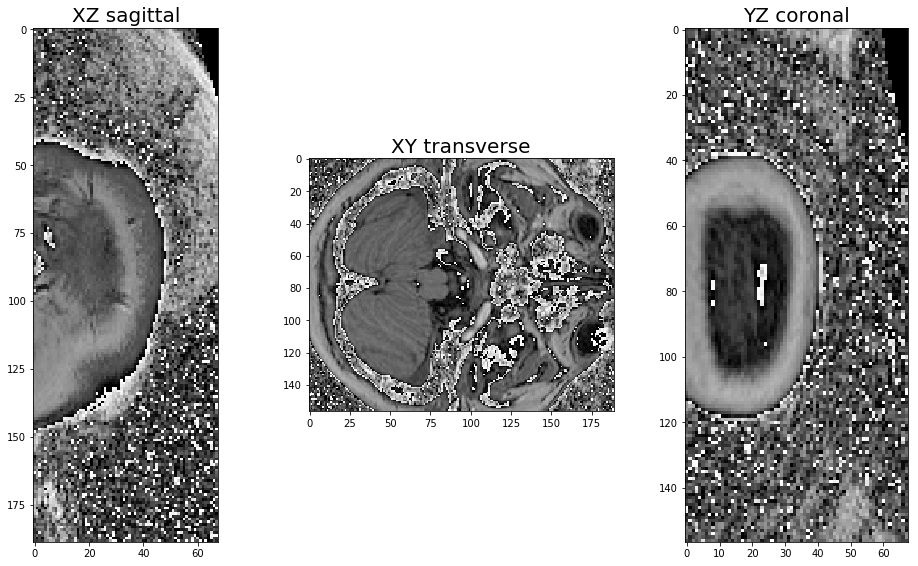

In [5]:
# here we create function to handle adjusting the contrast

from scipy import stats 
def contrast_rescale(imgs,minp,maxp,replace=None):
  # the denoising methods sometimes produce null edges so we need to find those
  """
  #find foreground-background
  fgd = imgs > 0.4 # JKJ change here
  obj = ndimage.find_objects(fgd)
  sample = imgs[obj[0]]
  """
  
  #find the max and min values, and adjust a bit. 
  vmin, vmax = stats.scoreatpercentile(imgs, (minp, maxp))

  #rescale the values, since scikit-image algorithms require floating-point images to have values between 0 and 1
  imgs = np.clip(imgs, vmin, vmax)
  imgs = (imgs - vmin) / (vmax - vmin)
  
  #"""
  #find foreground-background
  if replace is not None:
    fgd = imgs <= 0.4 # JKJ change here
    obj = ndimage.find_objects(fgd)
    imgs[obj[0]]=replace[obj[0]]
  else:
    fgd = imgs > 0.4 # JKJ change here
    obj = ndimage.find_objects(fgd)
    imgs = imgs[obj[0]]
    print('no replacement')
  #"""
  return imgs


sample=contrast_rescale(imgs,1,99)
#show the first image of the stack along each imaging plane
plot_3_planes(sample)

> For more advanced contrast operation, the OpenCV library provides more tools such as CLAHE and Enhance Local Contrast algorithms. Using them for this example seems a bit overkill, but they are very powerful when dealing with worse quality images.
>
>Now the pre-processing is done, following operations will be made to the already-processed array 'sample'.



~ text quoted from [example 3](http://42eli.github.io/)

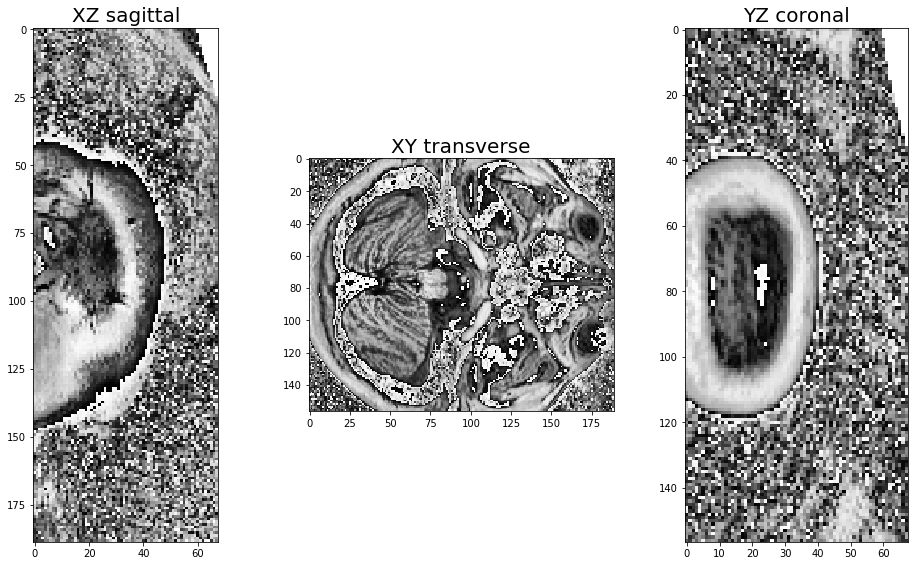

In [6]:
# this is an example of advanced contrast which is not useful in either the original or this new context
from cv2 import createCLAHE
from cv2 import cvtColor


clahe = createCLAHE(clipLimit=0.1*255, tileGridSize=(3,3))

def apply_CLAHE2plane(img_plane):
  try:
    img_plane = np.squeeze(img_plane)
    img_plane = 255*img_plane
    img_plane = clahe.apply(img_plane.astype(np.uint8))
    img_plane = img_plane.astype(np.float64)/255.0
  except:
    print('error')
    print(len(np.unique(img_plane)))
    img_plane = np.squeeze(img_plane)
    print(len(np.unique(img_plane)))
    img_plane = 255*img_plane
    print(np.unique(img_plane.astype(np.uint8)))
    img_plane = clahe.apply(img_plane.astype(np.uint8))
    img_plane = img_plane.astype(np.float64)/255.0
    print(np.unique(img_plane))
    
  return img_plane
 
def apply_CLAHE2stack(img_stack):
  # denoise XZ plane images
  for ndx in range(img_stack.shape[2]):
    img_stack[:,:,ndx] = apply_CLAHE2plane(img_stack[:,:,ndx]) # JKJ modified to correct for non-existance of 3D CLAHE_imgs restoration
  # denoise YZ plane images
  for ndx in range(img_stack.shape[1]):
    img_stack[:,ndx,:] = apply_CLAHE2plane(img_stack[:,ndx,:]) # JKJ modified to correct for non-existance of 3D CLAHE_imgs restoration
  # denoise XY plane images
  for ndx in range(img_stack.shape[0]):
    img_stack[ndx,:,:] = apply_CLAHE2plane(img_stack[ndx,:,:]) # JKJ modified to correct for non-existance of 3D CLAHE_imgs restoration
    return img_stack



plot_3_planes(apply_CLAHE2stack(1.0-imgs))


###De-noising
>De-noising is the process that reduce noises and artefacts on the image.
>
>The overall quality of this image is very good, apart from some noisy points which are simple 'salt and pepper' type noises.
>Bilateral filter, median filter and morphological filter are all effective for this type of noise. More advanced algorithms such as Non-local-means and FFT can handle more tricky types of noices and artefacts.
>
>Sometimes a spetial combination of adjustments, filters and convertions (a 'recipe') is needed for highly noised and distorted images.

~ text quoted from [example 3](http://42eli.github.io/)

In [7]:
#use a bilateral filter to denoise the subtle 'salt and pepper' in the images 
from skimage import restoration
from copy import deepcopy
# the bilateral filtering can only work in 2D so we have to move in 3 planes 
bilateral=sample.copy()
print(bilateral.shape)
# denoise XZ plane images
max_ndcs=deepcopy(bilateral.shape)
for ndx in range(max_ndcs[2]):
  bilateral[:,:,ndx] = restoration.denoise_bilateral(np.squeeze(bilateral[:,:,ndx]),multichannel=False) # JKJ modified to correct for non-existance of 3D bilateral restoration
  # correct for edge distortion
bilateral=contrast_rescale(bilateral,1,99,replace=sample)
# denoise YZ plane images
for ndx in range(max_ndcs[1]):
  bilateral[:,ndx,:] = restoration.denoise_bilateral(np.squeeze(bilateral[:,ndx,:]),multichannel=False) # JKJ modified to correct for non-existance of 3D bilateral restoration
bilateral=contrast_rescale(bilateral,1,99,replace=sample)
# denoise XY plane images
for ndx in range(max_ndcs[0]):
  bilateral[ndx,:,:] = restoration.denoise_bilateral(np.squeeze(bilateral[ndx,:,:]),multichannel=False) # JKJ modified to correct for non-existance of 3D bilateral restoration
bilateral=contrast_rescale(bilateral,1,99,replace=sample)


tv = restoration.denoise_tv_chambolle(sample,weight=0.1) # JKJ change the weight
tv=contrast_rescale(tv,1,99)


nl_mean = restoration.denoise_nl_means(sample,multichannel=False,patch_size=3, patch_distance=7, h=0.1)
nl_mean=contrast_rescale(nl_mean,1,99)

# try a "recipe" doing two denoising algorithms you can find a joint optimum by iterating two weak versions of an algorithm (if it's iterative)
bl2nl = restoration.denoise_nl_means(bilateral,multichannel=False,patch_size=3, patch_distance=7, h=0.1)
bl2nl=contrast_rescale(bl2nl,1,99)

print(bilateral.shape)

(157, 189, 68)
no replacement
no replacement
no replacement
(157, 189, 68)


/usr/local/lib/python2.7/dist-packages/matplotlib/tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


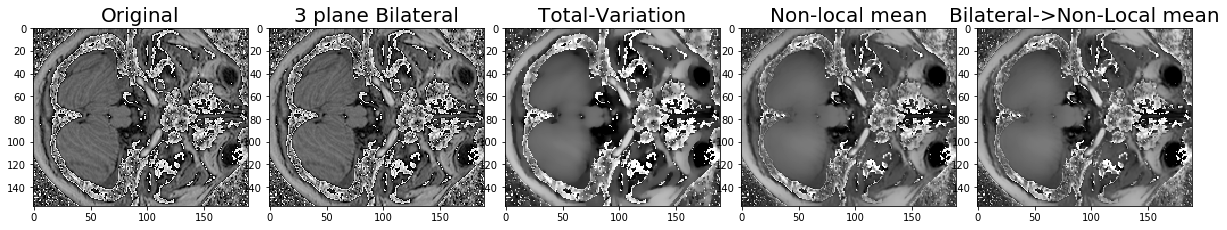

In [8]:
# plot the result of various denoising

transverse_ndx=0
fig, axes = plt.subplots(nrows=1, ncols=5)
ax0, ax1, ax2, ax3, ax4= axes

ax0.imshow(sample[:,:,transverse_ndx],cmap='gray')
ax0.set_title('Original',fontsize=20)

ax1.imshow(bilateral[:,:,transverse_ndx],cmap='gray')
ax1.set_title('3 plane Bilateral',fontsize=20)

ax2.imshow(tv[:,:,transverse_ndx],cmap='gray')
ax2.set_title('Total-Variation',fontsize=20)

ax3.imshow(nl_mean[:,:,transverse_ndx],cmap='gray')
ax3.set_title('Non-local mean',fontsize=20)

ax4.imshow(bl2nl[:,:,transverse_ndx],cmap='gray')
ax4.set_title('Bilateral->Non-Local mean',fontsize=20)

plt.tight_layout()

fig.set_size_inches(25, 9)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
#ax2.imshow(nlm[0],cmap='gray')
#ax2.set_title('Non-Local-Means',fontsize=9)

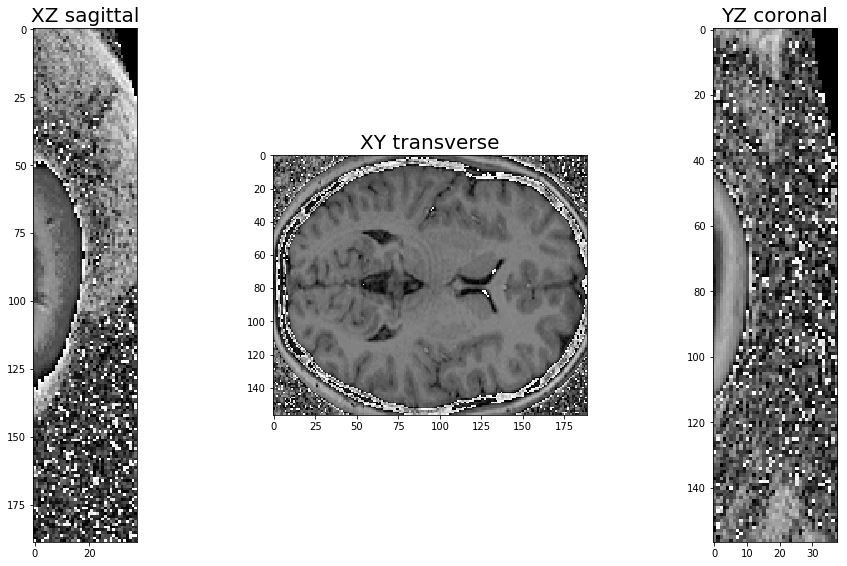

In [9]:
transverse_ndx=30
old_sample=sample.copy()
sample = bilateral #update the array by the best denoised array

plot_3_planes(sample[:,:,transverse_ndx:])

###Segmentation
Segmentation is the operation that classify the objects into meaningful catagories. In this case, the segmentation phases are :

* black      :cavities
* dark  gray :graymatter (and tissues with similar density)
* medium gray :whitematter (and tissues with similar density)
* light gray      :bone
* white      :fluids?

First I plot a histogram of voxel values to see how the values distributed:

Text(0.5,1,'Stacked Histogram of voxel values')

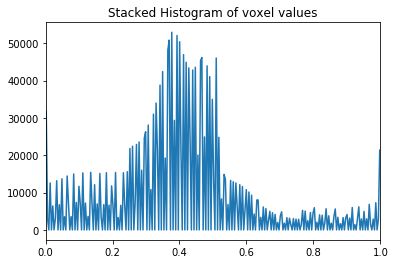

In [10]:
#Plot the histogram of the values in the array for assigning markers
from skimage import exposure
histo = exposure.histogram(sample)
plt.plot(histo[1], histo[0], label='data')
plt.xlim(0, 1)
plt.title('Stacked Histogram of voxel values')

>Set the thresholds of each phase according to the pattern of the histogram, then adjust it gently according to the markers showed later. You may need to do this repeatedly until the best result is found.

~ text quoted from [example 3](http://42eli.github.io/)

[1 2 3 4 5]


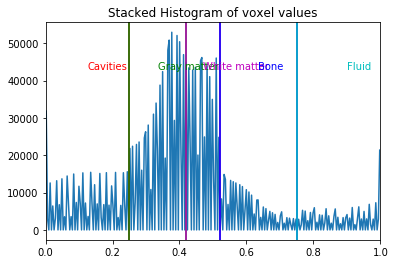

In [11]:
#Plot the histogram of the values in the array for assigning markers
from skimage import exposure
histo = exposure.histogram(sample)
plt.plot(histo[1], histo[0], label='data')
plt.xlim(0, 1)
plt.title('Stacked Histogram of voxel values')

#assign marker values based on the histogram
cavity=0.25
graymin=0.25
graymax=0.42
whitemin=0.42
whitemax=0.52
bonemin=0.52
bonemax=0.75
fluid=0.75

#visualise the phase domains
plt.axvline(cavity, color='r', ls='-')
plt.axvline(graymax, color='g', ls='-')
plt.axvline(graymin, color='g', ls='-')
plt.axvline(whitemin, color='m', ls='-')
plt.axvline(whitemax, color='m', ls='-')
plt.axvline(bonemin, color='b', ls='-')
plt.axvline(bonemax, color='b', ls='-')
plt.axvline(fluid, color='c', ls='-')
plt.text(cavity/2, np.max(histo)-10000, 'Cavities', color='r')
plt.text((graymin+graymax)/2, np.max(histo)-10000, 'Gray matter', color='g')    
plt.text((whitemin+whitemax)/2, np.max(histo)-10000, 'White matter', color='m')   
plt.text((bonemin+bonemax)/2, np.max(histo)-10000, 'Bone', color='b')
plt.text(0.9, np.max(histo)-10000, 'Fluid', color='c')
    
#assign gray markers:CTDOLO
markers = np.zeros(sample.shape, dtype=np.int8)
markers[sample < cavity] = 1 #cavities
markers[np.logical_and(sample > graymin, sample < graymax)] = 2 #gray matter
markers[np.logical_and(sample > whitemin, sample < whitemax)] = 3 #white matter
markers[np.logical_and(sample > bonemin, sample < bonemax)] = 4 #bone
markers[sample > fluid] = 5 #fluid
print(np.unique(markers))

Text(0.5,1,'Stacked Histogram of voxel values')

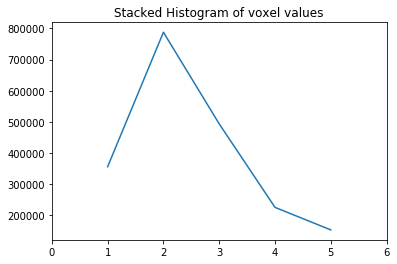

In [12]:
from skimage import exposure
histo = exposure.histogram(markers)
plt.plot(histo[1], histo[0], label='data')
plt.xlim(0, 6)
plt.title('Stacked Histogram of voxel values')

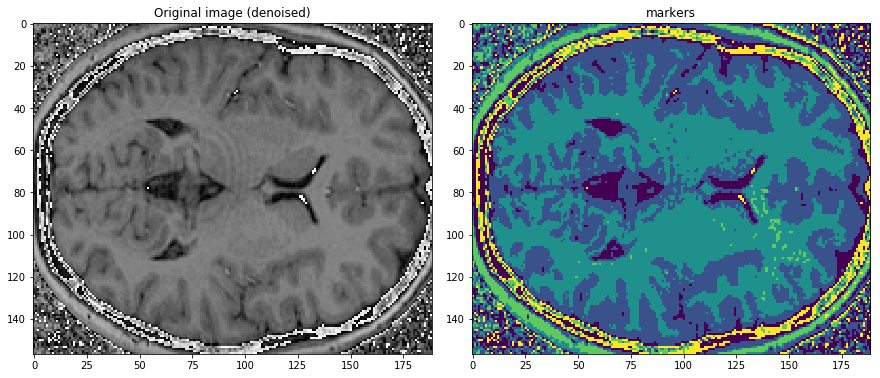

In [13]:
#check the markers
transverse_ndx=30
fig, axes = plt.subplots(ncols=2, figsize=(15, 15))
ax0, ax1= axes
ax0.imshow(sample[:,:,transverse_ndx], cmap='gray')
ax0.set_title("Original image (denoised)")
ax1.imshow(markers[:,:,transverse_ndx])
ax1.set_title("markers")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)

### segmentation finishing touches
Defining regions based on pixel density alone is likely to produce poor results. Look to examples [1](https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial) and [2](https://plot.ly/python/visualizing-mri-volume-slices/) for alternatives. However we can refine the segmentation with algorithms that adjust the identified surfaces. 

In [14]:
#Scikit randomwalker
from skimage import segmentation
rw = segmentation.random_walker(sample, markers, beta=500, mode='cg_mg', copy=False, return_full_prob=False)#beta=diffusion difficulty
#generate a possibility map for random walker
pm = segmentation.random_walker(sample, markers, beta=500, mode='cg_mg', copy=False, return_full_prob=True)#beta=diffusion difficulty

#Kmeans-clustering
from skimage.segmentation import slic
km = slic(sample, n_segments=5, compactness=0.01, multichannel=False, enforce_connectivity=False) 

#Scikit watershed 
from skimage.morphology import watershed as ws
ws = ws(sample, markers)

#OpenCV watershed:  can only work with 8bit 3-channel image
#cv2.watershed(sample,markers)

/usr/local/lib/python2.7/dist-packages/skimage/segmentation/random_walker_segmentation.py:382: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  warn('Random walker only segments unlabeled areas, where '


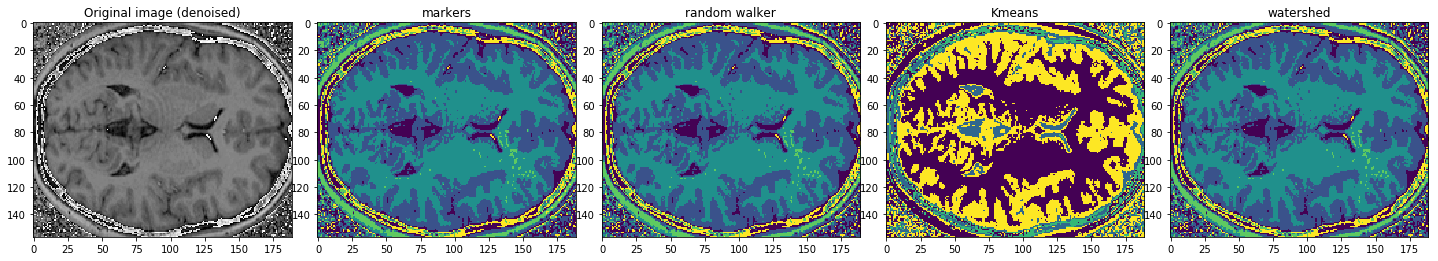

In [15]:
#check all the segmentation algorithms with simple 2D plots
transverse_ndx=30
fig, axes = plt.subplots(ncols=5, figsize=(25, 9))
ax0, ax1, ax2, ax3, ax4= axes
ax0.imshow(sample[:,:,transverse_ndx], cmap='gray')
ax0.set_title("Original image (denoised)")
ax1.imshow(markers[:,:,transverse_ndx])
ax1.set_title("markers")
ax2.imshow(rw[:,:,transverse_ndx])
ax2.set_title("random walker")
ax3.imshow(km[:,:,transverse_ndx])
ax3.set_title("Kmeans")
ax4.imshow(ws[:,:,transverse_ndx])
ax4.set_title("watershed")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)

>Mode for solving the linear system in the random walker algorithm:
>
>If no preference given, automatically attempt to use the fastest option available (‘cg_mg’ from pyamg >> ‘cg’ with UMFPACK > ‘bf’).
>
>* ‘bf’ (brute force): an LU factorization of the Laplacian is computed. This is fast for small images (\<1024x1024), but very slow and memory-intensive for large images (e.g., 3-D volumes).
>
>* ‘cg’ (conjugate gradient): the linear system is solved iteratively using the Conjugate Gradient method from scipy.sparse.linalg. This is less memory-consuming than the brute force method for large images, but it is quite slow.
>
>* ‘cg_mg’ (conjugate gradient with multigrid preconditioner): a preconditioner is computed using a multigrid solver, then the solution is computed with the Conjugate Gradient method. This mode requires that the pyamg module (http://pyamg.org/) is installed. For images of size > 512x512, this is the recommended (fastest) mode.

~ text quoted from [example 3](http://42eli.github.io/)

In [0]:
# define functions for returning a 3D object which we can use for calculations

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# this function gets the 3D object
def get_3d_obj(image,threshold=-300):
  verts, faces,_,_ = measure.marching_cubes_lewiner(image, level=threshold)
  # Fancy indexing: `verts[faces]` to generate a collection of triangles
  mesh = Poly3DCollection(verts[faces], alpha=0.70)
  return mesh,verts,faces
  
# this function does the plotting
def plot_3d(mesh, img_shape, fig, ax, threshold=-300, azimuth=80,elevation=0):
  # Position the scan upright, 
  # so the head of the patient would be at the top facing the camera
  # p = image.transpose(2,1,0)

  #fig = plt.figure(figsize=(10, 10))
  #ax = fig.add_subplot(111, projection='3d')
  face_color = [0.45, 0.45, 0.75]
  mesh.set_facecolor(face_color)
  ax.add_collection3d(mesh)

  ax.set_xlim(0, img_shape[0])
  ax.set_ylim(0, img_shape[1])
  ax.set_zlim(0, img_shape[2])
  ax.view_init(azimuth, elevation)
  
# this is a convenience function for combining the two above
def plot_wrapper(img_stack,threshold,fig,ax):
  mesh,verts,faces = get_3d_obj(img_stack,threshold=threshold)
  plot_3d(mesh, img_stack.shape, fig, ax, azimuth=90,elevation=0)
  return (verts,faces)

## View the 3D objects

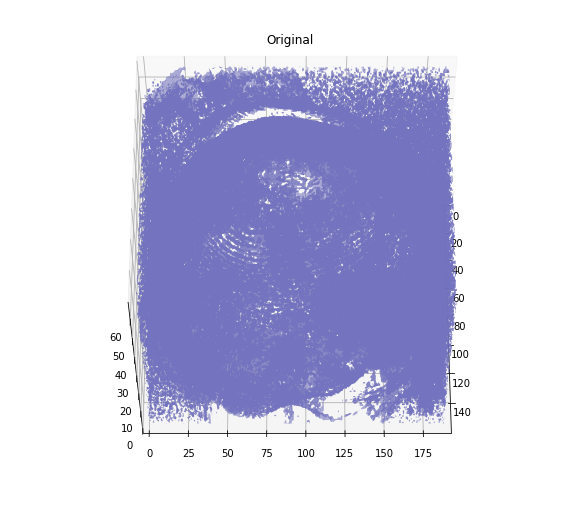

In [0]:
threshold=3
km_threshold=0
#fig, axes = plt.subplots(nrows=1,ncols=5)#, projection='3d')
fig = plt.figure(figsize=(10, 9))
#ax0, ax1, ax2, ax3, ax4 = axes

ax0 = fig.add_subplot(1,1,1, projection='3d')
original_mesh=plot_wrapper(sample,(whitemin+whitemax)/2,fig,ax0)
ax0.set_title('Original',fontsize=12)

fig.set_size_inches(10, 9)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)


plt.show()


In [0]:
threshold=3
km_threshold=0
#fig, axes = plt.subplots(nrows=1,ncols=5)#, projection='3d')
fig = plt.figure(figsize=(10, 9))
#ax0, ax1, ax2, ax3, ax4 = axes

ax1 = fig.add_subplot(1,1,1, projection='3d')
markers_mesh = plot_wrapper(markers,threshold-0.1, fig, ax1)
#ax1.imshow(markers[i])
ax1.set_title('Markers',fontsize=12)

fig.set_size_inches(10, 9)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)


plt.show()


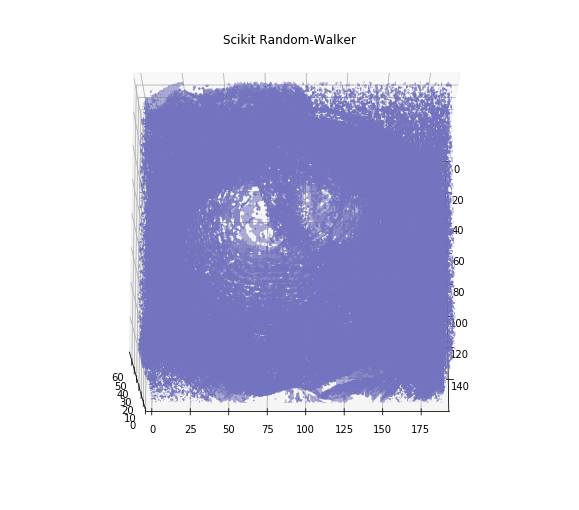

In [0]:
threshold=3
km_threshold=0
#fig, axes = plt.subplots(nrows=1,ncols=5)#, projection='3d')
fig = plt.figure(figsize=(10, 9))
#ax0, ax1, ax2, ax3, ax4 = axes

ax2 = fig.add_subplot(1,1,1, projection='3d')
rw_mesh = plot_wrapper(rw,threshold-0.1, fig, ax2)
#ax2.imshow(rw[i])
ax2.set_title('Scikit Random-Walker',fontsize=12)

fig.set_size_inches(10, 9)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)


plt.show()


In [0]:
threshold=3
km_threshold=0
#fig, axes = plt.subplots(nrows=1,ncols=5)#, projection='3d')
fig = plt.figure(figsize=(10, 9))
#ax0, ax1, ax2, ax3, ax4 = axes

ax3 = fig.add_subplot(1,1,1, projection='3d')
ws_mesh = plot_wrapper(ws,threshold-0.1, fig, ax3)
#ax3.imshow(ws[i])
ax3.set_title('Scikit Watershed',fontsize=12)

fig.set_size_inches(10, 9)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)


plt.show()


In [0]:
threshold=3
km_threshold=0
#fig, axes = plt.subplots(nrows=1,ncols=5)#, projection='3d')
fig = plt.figure(figsize=(10, 9))
#ax0, ax1, ax2, ax3, ax4 = axes

ax4 = fig.add_subplot(1,1,1, projection='3d') 
km_mesh = plot_wrapper(km,km_threshold-0.1, fig, ax4)
#ax4.imshow(km[i])
ax4.set_title('K-means clustering',fontsize=12)

fig.set_size_inches(10, 9)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)


plt.show()

In [19]:
# example of how to re-plot the 3D image
from copy import deepcopy
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1,1,1, projection='3d')
temp_mesh=Poly3DCollection(markers_mesh[0][markers_mesh[1]], alpha=0.70)
plot_3d(temp_mesh, markers.shape, fig, ax1)
ax1.set_title('Markers',fontsize=12)

RuntimeError: ignored

Error in callback <function flush_figures at 0x7f691e67dd70> (for post_execute):


KeyboardInterrupt: ignored

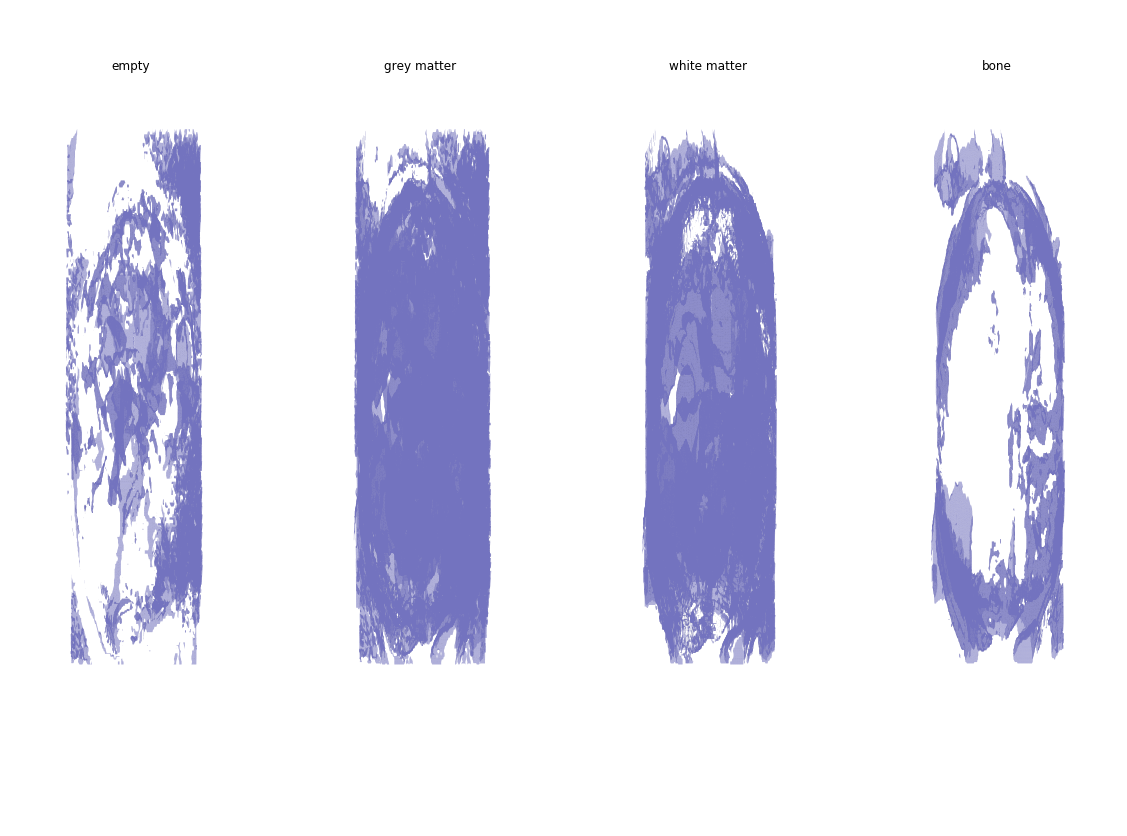

In [0]:

threshold=0.9
#fig, axes = plt.subplots(nrows=1,ncols=5)#, projection='3d')
fig = plt.figure(figsize=(25, 9))
#ax0, ax1, ax2, ax3, ax4 = axes
ax0 = fig.add_subplot(1,5,1, projection='3d')
pm0_mesh=plot_wrapper(pm[:,:,:,0],threshold,fig,ax0)
ax0.set_title('empty',fontsize=12)

ax1 = fig.add_subplot(1,5,2, projection='3d')
pm1_mesh=plot_wrapper(pm[:,:,:,1],threshold,fig,ax1)
#ax1.imshow(markers[i])
ax1.set_title('grey matter',fontsize=12)

ax2 = fig.add_subplot(1,5,3, projection='3d')
pm2_mesh=plot_wrapper(pm[:,:,:,2],threshold,fig,ax2)
#ax2.imshow(rw[i])
ax2.set_title('white matter',fontsize=12)

ax3 = fig.add_subplot(1,5,4, projection='3d')
pm3_mesh=plot_wrapper(pm[:,:,:,3],threshold,fig,ax3)
#ax3.imshow(ws[i])
ax3.set_title('fluid',fontsize=12)

fig.set_size_inches(25, 9)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)


plt.show()


>Now lets compare the difference percentage between two images.

~ text quoted from [example 3](http://42eli.github.io/)

In [0]:
from itertools import izip
k=0
def difper(k,a,b):
    i1 = Image.fromarray(a[k])
    i2 = Image.fromarray(b[k])
    pairs = izip(i1.getdata(), i2.getdata())

    dif = sum(abs(p1-p2) for p1,p2 in pairs)
        
    ncomponents = i1.size[0] * i1.size[1]
    per = (dif / 255.0 * 100) / ncomponents
    
    return per

'\n    difference = np.subtract(i1,i2)\n    plt.imshow(difference,cmap=\'Reds\')\n    plt.colorbar(ticks=[0,1,2,3])\n    \n#    plt.axis(\'off\')\n    plt.title(\'Difference Percentage = %f\' % per , fontsize=9) #f=floating point decimal format\n    plt.savefig("difper%04d.png"%k,bbox_inches=\'tight\',dpi=250) #04d zeropadded integer\n    plt.close()\n'

In [0]:
a=0
for i in range(len(infiles)):   
    a += difper(i,sample,rw)
b=0
for i in range(len(infiles)):   
    b += difper(i,sample,ws)

print 'Average difference of denoised original and Random walker =', a/len(infiles), '%'
print 'Average difference of denoised original and Watershed =', b/len(infiles), '%'

Average difference of denoised original and Random walker = 0.959354647416 %
Average difference of denoised original and Watershed = 0.959354647416 %


http://42eli.github.io/

https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial 

https://plot.ly/python/visualizing-mri-volume-slices/

see also
https://pythonprogramming.net/3d-convolutional-neural-network-machine-learning-tutorial/